In [3]:
import time
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from math import *
from sklearn import metrics
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
print(__doc__)
#
#pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
# plot plots inline
#%matplotlib inline 

In [ ]:
trn_all = pd.read_csv('../data/train.csv')  # column #0 in our file is index
# trn_1 = pd.read_csv('../data/train_1.csv', index_col=0)

In [6]:
#selected features and Cut off outliers of Expected >= 69
trn_new = trn_all[trn_all['Expected']<69]

In [7]:
print(trn_new.columns)

Index([u'Id', u'minutes_past', u'radardist_km', u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th', u'Expected'],
      dtype='object')


In [8]:
#combine observations with same ID by using mean
#replace Nan by overall mean
trn_mean = trn_new.groupby(trn_new.Id).agg(['mean', 'median', 'std', 'count', 'min', 'max'])
trn_mean.columns = ['_'.join(col).strip() for col in trn_mean.columns.values]
#trn_mean = trn_mean.drop(['Expected_count', 'Expected_median', 'Expected_std', 'Expected_min', 'Expected_max'], axis =1)

In [21]:
print(trn_mean.columns)

Index([u'minutes_past_mean', u'minutes_past_median', u'minutes_past_std',
       u'minutes_past_count', u'minutes_past_min', u'minutes_past_max',
       u'radardist_km_mean', u'radardist_km_median', u'radardist_km_std',
       u'radardist_km_count',
       ...
       u'Kdp_5x5_90th_std', u'Kdp_5x5_90th_count', u'Kdp_5x5_90th_min',
       u'Kdp_5x5_90th_max', u'Expected_mean', u'Expected_median',
       u'Expected_std', u'Expected_count', u'Expected_min', u'Expected_max'],
      dtype='object', length=138)


In [22]:
# ignore id's where all Ref vales are NaN
trn_mean = trn_mean[pd.notnull(trn_mean.Ref_mean)]

In [23]:
index2 = list(trn_mean)
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

trn_mean= pd.DataFrame(imp.fit_transform(trn_mean),index = trn_mean.index, columns=index2)

In [24]:
#train and test data preparation
X_trn = trn_mean.loc[:,'minutes_past_mean':'Kdp_5x5_90th_max'].values
y_trn = np.log1p(trn_mean.loc[:,'Expected_mean'].values)

In [26]:
clf = ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=1, random_state=0, n_jobs=5)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number

In [27]:
#train model
t = time.time()
clf.fit(X_trn, y_trn)
print time.time()-t

1312.01620913


In [28]:
#generate test result
test_new = pd.read_csv('../data/test.csv')

#combine observations with same ID by using mean
#replace Nan by overall mean
test_mean = test_new.groupby(test_new.Id).agg(['mean', 'median', 'std', 'count', 'min', 'max'])
test_mean.columns = ['_'.join(col).strip() for col in test_mean.columns.values]

index2 = list(test_mean)
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
test_mean= pd.DataFrame(imp.fit_transform(test_mean),index=test_mean.index,columns=index2)

test_X =test_mean.loc[:,'minutes_past_mean':'Kdp_5x5_90th_max'].values

test_y_predict = np.exp(clf.predict(test_X))-1

In [30]:
#generate output file
#0.75 from prediction and 0.25 from marshall palmer
marshall = pd.read_csv('../data/MP_r_09.csv')

test_result_exist = pd.DataFrame()
test_result_exist['Id'] = test_mean.index
test_result_exist['Expected'] = test_y_predict

test_result = pd.DataFrame()
test_result['Id'] = test_new['Id'].unique()
test_result = pd.merge(test_result, test_result_exist, how='left', on=['Id'], sort=True)
#test_result.loc[test_result['Expected'].isnull(), 'Expected'] = marshall.loc[test_result['Expected'].isnull(), 'Expected']
test_result.loc[test_result['Expected'].notnull(), 'Expected'] = 0.75*test_result.loc[test_result['Expected'].notnull(), 'Expected']+0.25*marshall.loc[test_result['Expected'].notnull(), 'Expected']

test_result.to_csv('../data/extraRandom_result_11_19.csv', index=False)

In [74]:
#feature importance
importance = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importance)[::-1]

#print(len(indices))

print("Feature ranking:")

for count in range(len(indices)):
    print("feature %s (%d) (%f)" % (test_mean.columns[indices[count]], indices[count], importance[indices[count]]))
  

Feature ranking:
feature Ref_5x5_90th_max (35) (0.042035)
feature Ref_max (17) (0.038750)
feature Ref_5x5_50th_max (29) (0.038686)
feature Ref_5x5_10th_max (23) (0.034208)
feature Ref_5x5_90th_mean (30) (0.027373)
feature RefComposite_5x5_50th_max (53) (0.022057)
feature RefComposite_max (41) (0.017698)
feature RefComposite_5x5_10th_max (47) (0.017455)
feature Ref_5x5_50th_mean (24) (0.017116)
feature Ref_mean (12) (0.016653)
feature RefComposite_5x5_90th_max (59) (0.016215)
feature RefComposite_5x5_90th_mean (54) (0.015652)
feature Ref_5x5_90th_median (31) (0.015251)
feature radardist_km_min (10) (0.015101)
feature radardist_km_median (7) (0.014125)
feature radardist_km_mean (6) (0.013263)
feature radardist_km_max (11) (0.012517)
feature Ref_5x5_10th_mean (18) (0.012373)
feature RefComposite_5x5_50th_mean (48) (0.011819)
feature minutes_past_std (2) (0.010588)
feature Ref_5x5_50th_median (25) (0.010212)
feature RefComposite_mean (36) (0.009661)
feature minutes_past_min (4) (0.009575)


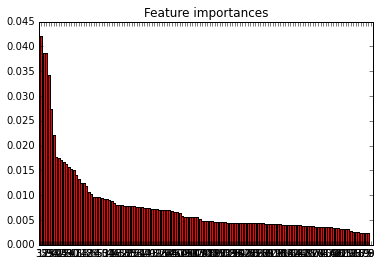

In [87]:
#plot figure importance in bar and save ./multipage.pdf
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.figure()
plt.title("Feature importances")
#plt.bar(range(len(indices)), importance[indices],color="r", yerr=std[indices], align="center")
plt.bar(range(len(indices)), importance[indices],color="r", align="center")
plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
pp = PdfPages('./multipage.pdf')
plt.savefig(pp, format='pdf')
#pp.savefig()
pp.close()
plt.show()

